# lesson 4 ALS算法与推荐系统

## Thinking1 ALS都有哪些应用场景
- ALS主要是用于矩阵分解目标函数的优化方法,针对显式评分矩阵,先随机生成X和Y,然后然后固定一个求解另一个.这样交替进行下去，直到取得最优解    
- ALS还可以对隐式矩阵进行分解：  
将评分看成行为的强度，比如浏览次数，阅读时间   
当rui >0 时，用户u对商品i有行为   
当rui <0 时，用户u对商品i没有行为  
再对隐式矩阵进行分解,将目标函数转化为矩阵形式，并进行求导,利用ALS方法优化参数

## Thinking2 ALS进行矩阵分解的时候，为什么可以并行化处理
矩阵分解并相乘过程中，结果矩阵中的每个元素都是可以独立计算的，即彼此之间并无依赖性。所以可采用并行化处理，将会显著地提高计算效率。

## Thinking3 梯度下降法中的批量梯度下降（BGD），随机梯度下降（SGD），和小批量梯度下降有什么区别（MBGD）
- Batch Gradient Descent批量梯度下降：  
  批量梯度下降法是最原始的形式，它是指在每一次迭代时使用所有样本来进行梯度的更新。(对目标函数求偏导,每次迭代对参数进行更新)要不断重复这一步直到算法收敛，也就是参数不断更新，直到梯度为0。   
  优点：   
  （1）一次迭代是对所有样本进行计算，此时利用矩阵进行操作，实现了并行。    
  （2）由全数据集确定的方向能够更好地代表样本总体，从而更准确地朝向极值所在的方向。当目标函数为凸函数时，BGD一定能够得到全局最优。   
  缺点：   
  （1）当样本数目 m很大时，每迭代一步都需要对所有样本计算，训练过程会很慢。   
  
- Stochastic Gradient Descent随机梯度下降    
  随机梯度下降法不同于批量梯度下降，它的具体思路是：算法中的每次更新不需要再全部遍历一次整个样本，只需要查看一个训练样本进行更新，之后再用下一个样本进行下一次更新，像批梯度下降一样不断迭代更新。   
  优点：  
  （1）由于不是在全部训练数据上的损失函数，而是在每轮迭代中，随机优化某一条训练数据上的损失函数，这样每一轮参数的更新速度大大加快。  
  缺点：   
  （1）准确度下降。由于即使在目标函数为强凸函数的情况下，SGD仍旧无法做到线性收敛。    
  （2）可能会收敛到局部最优，由于单个样本并不能代表全体样本的趋势。    
  （3）不易于并行实现。
- Mini-Batch Gradient Descent小批量梯度下降  
  小批量梯度下降法的初衷便是算法的训练过程比较快，而且也要保证最终参数训练的准确率，MBGD在每次更新参数时使用b个样本   
  优点：   
  （1）通过矩阵运算，每次在一个batch上优化参数并不会比单个数据慢太多。   
  （2）每次使用一个batch可以大大减小收敛所需要的迭代次数，同时可以使收敛到的结果更加接近梯度下降的效果。   
  （3）可实现并行化。  
  缺点：  
  （1）batch_size的不当选择可能会带来一些问题。

## Thinking4 你阅读过和推荐系统/计算广告/预测相关的论文么？有哪些论文是你比较推荐的，可以分享到微信群中
### Tree-enhanced embedding Model for Explainable Recommendation   
论文链接:https://www.paperweekly.site/papers/2548     
本文由新加坡国立大学发表于 WWW 2018 。在推荐系统任务上，基于 embedding 的方法虽然具有良好的推荐表现，但其整体仿若一个黑盒，难以解释具体推荐原因。相反，基于决策树的推荐方法则能够从数据中进行规则推理，进而给出具体的决策原因。    
本文的写作动机便是将二者的优势加以结合，提出一个全新的 Tree-enhanced Embedding 方法，既保持基于决策树方法的可解释性，又具备基于 embedding 方法的良好推荐效果，进而保证了整个推荐过程的透明、可解释性。

## Action1 "对MovieLens数据集进行评分预测
工具：可以使用Surprise或者其他
说明使用的模型，及简要原理"


In [42]:
from surprise import Dataset, Reader, BaselineOnly, KNNBasic, NormalPredictor, accuracy
from surprise.model_selection import KFold

#加载数据
reader = Reader(line_format='user item rating timestamp',sep=',',skip_lines=1) #读取的数据必须至少包含三列数据： user、item、ratings
data = Dataset.load_from_file('./ratings.csv',reader = reader)
#train_set = data.build_full_trainset()

### surprise 工具中的baseline 算法:   
对于总体的评分设置一个基础评分u    
bui 为预计评分   
bu  为用户相对于整体的偏差(客户评分相对更苛刻或更宽松)  
bi  为商品相对于整体的偏差(商品比较优秀或者评分较低)  
bui = u +bu +bi

In [43]:
def prediction(method):
    # Baseline算法，使用ALS进行优化
    if method =='ALS':
        bsl_options = {'method': 'als','n_epochs': 5,'reg_u': 12,'reg_i': 5}
        algo = BaselineOnly(bsl_options=bsl_options)
    #使用SGD进行优化
    elif method =='SGD':
        bsl_options = {'method': 'sgd','n_epochs': 5}
        algo = BaselineOnly(bsl_options=bsl_options)
     
    # 定义K折交叉验证迭代器，K=3
    kf = KFold(n_splits=3)
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        predictions = algo.test(testset)
        accuracy.rmse(predictions, verbose=True)
    return algo

### baseline 算法 使用ALS 优化方法  
baseline 算法目标函数为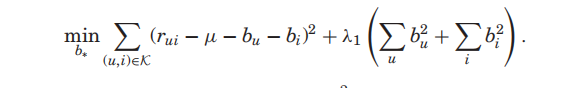
使用ALS进行优化   
Step1，固定bu，优化bi  
Step2，固定bi，优化bu  

In [46]:
method ='ALS'
algo = prediction(method)
uid = str(196)
iid = str(302)
pred = algo.predict(uid, iid, verbose=True)
print('{}优化方法下,{}号用户对于{}号电影的预计评分为{:.2f}'.format(method,uid,iid,pred.est))

Estimating biases using als...
RMSE: 0.8645
Estimating biases using als...
RMSE: 0.8634
Estimating biases using als...
RMSE: 0.8634
user: 196        item: 302        r_ui = None   est = 4.11   {'was_impossible': False}
ALS优化方法下,196号用户对于302号电影的预计评分为4.11


### SGD 优化方法   
基本思路是以随机方式遍历训练集中的数据，并给出每个已知评分的预测评分。用户和物品特征向量的调整就沿着评分误差越来越小的方向迭代进行，直到误差达到要求。

In [47]:
method = "SGD"
algo = prediction(method)
uid = str(196)
iid = str(302)
pred = algo.predict(uid,iid,verbose= True)
print('{}优化方法下,{}号用户对于{}号电影的预计评分为{:.2f}'.format(method,uid,iid,pred.est))

Estimating biases using sgd...
RMSE: 0.8740
Estimating biases using sgd...
RMSE: 0.8759
Estimating biases using sgd...
RMSE: 0.8731
user: 196        item: 302        r_ui = None   est = 4.06   {'was_impossible': False}
SGD优化方法下,196号用户对于302号电影的预计评分为4.06


## Action2 "Paper Reading：Slope one predictors for online rating-based collaborative filtering. Daniel Lemire and Anna Maclachlan, 2007. http://arxiv.org/abs/cs/0702144.   
## 积累，总结笔记，自己的思考及idea    
该论文介绍了一种评分协同过滤算法-slope one 其优点是算法很简单, 易于实现, 效率高且推荐准确度较高.    
其计算方式为:   
   Step1，计算Item之间的评分差的均值，记为评分偏差（两个item都评分过的用户）    
   Step2，根据Item间的评分偏差和用户的历史评分，预测用户对未评分的item的评分      
   Step3，将预测评分排序，取topN对应的item推荐给用户    
文章中还介绍了两种改进的slope one 算法 
  - the weighted slope one scheme  
  - the Bi-polar slope on scheme   
  
SlopeOne算法的特点：    
适用于item更新不频繁，数量相对较稳定   
item数<<user数   
算法简单，易于实现，执行效率高   
依赖用户行为，存在冷启动问题和稀疏性问题

思考: 
在符合数据集特点的情况下,一些简单且可解释性强的算法可能会更好的发挥预测作用  

## Action3 "设计你自己的句子生成器
grammar = '''
战斗 => 施法  ， 结果 。   
施法 => 主语 动作 技能     
结果 => 主语 获得 效果   
主语 => 张飞 | 关羽 | 赵云 | 典韦 | 许褚 | 刘备 | 黄忠 | 曹操 | 鲁班七号 | 貂蝉  
动作 => 施放 | 使用 | 召唤   
技能 => 一骑当千 | 单刀赴会 | 青龙偃月 | 刀锋铁骑 | 黑暗潜能 | 画地为牢 | 守护机关 | 狂兽血性 | 龙鸣 | 惊雷之龙 | 破云之龙 | 天翔之龙  
获得 => 损失 | 获得   
效果 => 数值 状态  
数值 => 1 | 1000 |5000 | 100   
状态 => 法力 | 生命  
'''" 


In [1]:
import random

# 定语从句语法
grammar = '''
战斗 => 施法  ， 结果 。
施法 => 主语 动作 技能 
结果 => 主语 获得 效果
主语 => 张飞 | 关羽 | 赵云 | 典韦 | 许褚 | 刘备 | 黄忠 | 曹操 | 鲁班七号 | 貂蝉
动作 => 施放 | 使用 | 召唤 
技能 => 一骑当千 | 单刀赴会 | 青龙偃月 | 刀锋铁骑 | 黑暗潜能 | 画地为牢 | 守护机关 | 狂兽血性 | 龙鸣 | 惊雷之龙 | 破云之龙 | 天翔之龙
获得 => 损失 | 获得 
效果 => 数值 状态
数值 => 1 | 1000 |5000 | 100 
状态 => 法力 | 生命
'''


In [2]:
# 得到语法字典
def getGrammarDict(gram, linesplit = "\n", gramsplit = "=>"):
    #定义字典
    result = {}

    for line in gram.split(linesplit):
        # 去掉首尾空格后，如果为空则退出
        if not line.strip(): 
            continue
        expr, statement = line.split(gramsplit)
        result[expr.strip()] = [i.split() for i in statement.split("|")]
    #print(result)
    return result

getGrammarDict(grammar)

{'战斗': [['施法', '，', '结果', '。']],
 '施法': [['主语', '动作', '技能']],
 '结果': [['主语', '获得', '效果']],
 '主语': [['张飞'],
  ['关羽'],
  ['赵云'],
  ['典韦'],
  ['许褚'],
  ['刘备'],
  ['黄忠'],
  ['曹操'],
  ['鲁班七号'],
  ['貂蝉']],
 '动作': [['施放'], ['使用'], ['召唤']],
 '技能': [['一骑当千'],
  ['单刀赴会'],
  ['青龙偃月'],
  ['刀锋铁骑'],
  ['黑暗潜能'],
  ['画地为牢'],
  ['守护机关'],
  ['狂兽血性'],
  ['龙鸣'],
  ['惊雷之龙'],
  ['破云之龙'],
  ['天翔之龙']],
 '获得': [['损失'], ['获得']],
 '效果': [['数值', '状态']],
 '数值': [['1'], ['1000'], ['5000'], ['100']],
 '状态': [['法力'], ['生命']]}

In [6]:
# 生成句子
def generate(gramdict, target, isEng = False):
    if target not in gramdict: 
        return target
    find = random.choice(gramdict[target])
    #print(find)
    blank = ''
    # 如果是英文中间间隔为空格
    if isEng: 
        blank = ' '
    return blank.join(generate(gramdict, t, isEng) for t in find)

In [10]:
gramdict = getGrammarDict(grammar)
print(generate(gramdict,"战斗"))

曹操施放单刀赴会，赵云损失1000生命。
